## Schroeder Reverb
#### Annie Chu | October 12, 2021
Implementing a Schroeder reverb via feedback comb filter & all pass difference equations.

In [74]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import simpleaudio as sa
from matplotlib.pyplot import figure


#### Feedback Comb & All Pass Filters via Difference Equations

In [5]:
# creating feedback comb filter
def comb(x_n, g, d):
    # x_n is numpy array of initial samples
    y_n = np.zeros(len(x_n));
    for i in range(len(x_n)):
        if i-d < 0:
            y_n[i] = x_n[i]
        else:
            y_n[i] = x_n[i] + g*y_n[i-d]
    return y_n

In [ ]:
#testing comb
x1 = np.array([1.0, 0.1, -0.1])

y1 = comb(x1, 0.5, 1)
y2 = comb(x1, 0.5, 1)

print(y1)
print(y1+y2)

In [8]:
# creating all pass filter
def allpass(x_n, g, d):
    # x_n is numpy array of initial samples
    y_n = np.zeros(len(x_n));
    for i in range(len(x_n)):
        if i-d < 0:
            y_n[i] = g*x_n[i]
        else:
            y_n[i] = g*x_n[i] + x_n[i-d] - g*y_n[i-d]
    return y_n

In [7]:
#testing all pass
x1 = np.array([1.0, 0.1, -0.1])

allpass(x1, 0.5, 1)

array([ 0.5 ,  0.8 , -0.35])

#### Creating Schroeder Reverb
Implementing SATREV Schroeder Reverb developed by Prof. John Chowning

https://ccrma.stanford.edu/~jos/pasp/Example_Schroeder_Reverberators.html


In [50]:
def schroeder(x):
    yc1 = comb(x, 0.805, 901) 
    yc2 = comb(x, 0.827, 778)
    yc3 = comb(x, 0.783, 1011)
    yc4 = comb(x, 0.764, 1123)

    yc_out = yc1 + yc2 + yc3 + yc4
    yap1 = allpass(yc_out, 0.7, 125)
    yap2 = allpass(yap1, 0.7, 42)
    yap3 = allpass(yap2, 0.7, 12)
    y_final = yap3 + 0.7*x
    return y_final

In [10]:
#testing schroeder
x = np.array([1.0, 0.1, -0.1]) #input signal
print(x)
print(schroeder(x))

[ 1.   0.1 -0.1]
[ 2.072   0.2072 -0.2072]


#### Applying Reverb to .wav file 
Testing with Cantina Band (3s) file from https://www2.cs.uic.edu/~i101/SoundFiles/

In [12]:
audiofile = "/Users/anniechu/Desktop/CantinaBand3.wav"
fs, cb_data = wavfile.read(audiofile)

In [53]:
#checking cb_data contents
print(f".Wav Contents = {cb_data}")
print(f".Wav Shape = {cb_data.shape}")
length = cb_data.shape[0] / fs
print(f".Wav Length = {length}s")
print(f"Sampling Rate= {fs} Hz")


.Wav Contents = [   3    7    0 ...  -12 -427 -227]
.Wav Shape = (66150,)
.Wav Length = 3.0s
Sampling Rate= 22050 Hz


In [29]:
#playing original cantina band .wav file
wave_obj = sa.WaveObject.from_wave_file(audiofile)
play_obj = wave_obj.play()
#play_obj.wait_done()

In [30]:
play_obj.stop()

In [42]:
#adding reverb to cantina band .wav file
rv_cb = schroeder(cb_data)

#checking original vs reverbed array
print(f"ORIGINAL = {len(cb_data)} | {cb_data}")
print(f"REVERBED = {len(rv_cb)} | {rv_cb}")

ORIGINAL = 66150 | [   3    7    0 ...  -12 -427 -227]
REVERBED = 66150 | [    6.216         14.504          0.         ...  2553.81846747
   381.28899904 -1742.61019732]


In [65]:
#normalizing & converting for analogue output (dac)
rv_cb1=np.int16(rv_cb/np.max(np.abs(rv_cb)) * 32767)
cb_data1 =np.int16(cb_data/np.max(np.abs(cb_data)) * 32767)

print(rv_cb1)
print(cb_data1)


[    5    12     0 ...  2163   323 -1476]
[   10    25     0 ...   -43 -1554  -826]


#### Audio Comparison: original vs reverbed version

In [68]:
#original
play_obj = sa.play_buffer(cb_data1, 1, 2, fs)

In [69]:
play_obj.stop()

In [70]:
#reverbed -- is louder than original, anyway to equalize?
play_obj = sa.play_buffer(rv_cb1, 1, 2, fs)

In [71]:
play_obj.stop()

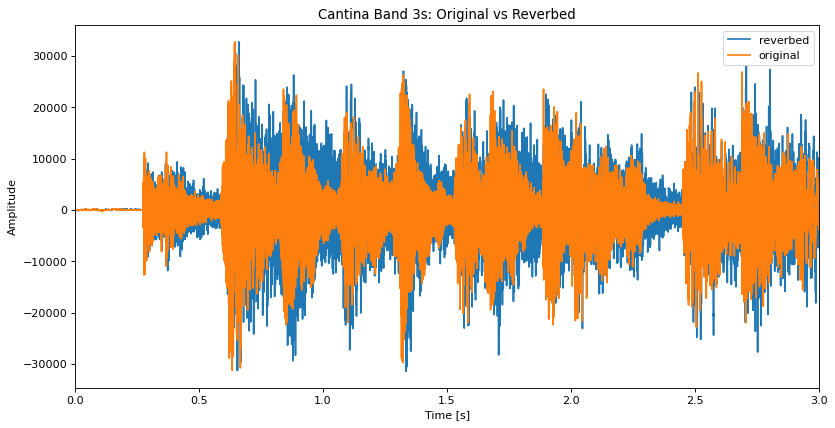

In [82]:
figure(figsize=(12, 6), dpi=80)
time = np.linspace(0., length, cb_data.shape[0])
plt.plot(time, rv_cb1, label="reverbed")
plt.plot(time, cb_data1, label="original")
plt.xlim(0, 3)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Cantina Band 3s: Original vs Reverbed")
plt.show()

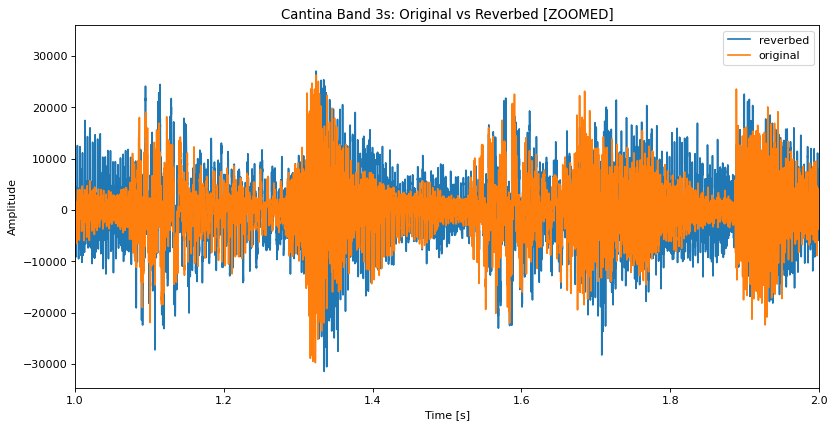

In [83]:
figure(figsize=(12, 6), dpi=80)
time = np.linspace(0., length, cb_data.shape[0])
plt.plot(time, rv_cb1, label="reverbed")
plt.plot(time, cb_data1, label="original")
plt.xlim(1, 2)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Cantina Band 3s: Original vs Reverbed [ZOOMED]")
plt.show()